In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [36]:
import pandas as pd
import matplotlib as plt
import seaborn as sbn
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn.model_selection import train_test_split,  GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV, ElasticNetCV, LinearRegression, LassoCV
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
warnings.filterwarnings('ignore')
%matplotlib inline

# Pre-processing using imputation

## Separating training and test data

In [6]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_train = pd.read_csv("train.csv")
df_train = df_train.drop('Id', axis = 1)
df_test = df_test.drop("Id", axis = 1)

#training data features
train_numerics = df_train.select_dtypes(include=[np.number])
#train_numerics = train_numerics.drop('SalePrice', axis = 1)
train_categorics = df_train.select_dtypes(include = ["object"])
print("There are", train_numerics.shape[1]," numeric features and", train_categorics.shape[1]," categorical features in the training data.")
#test data features
test_numerics = df_test.select_dtypes(include=[np.number])
test_categorics = df_test.select_dtypes(include = ["object"])
print("There are", test_numerics.shape[1]," numeric features and", test_categorics.shape[1]," categorical features in the test data.")

There are 37  numeric features and 43  categorical features in the training data.
There are 36  numeric features and 43  categorical features in the test data.


In [7]:
print(train_numerics.isna().sum().max())

259


## Searching for outliers

First we plot a correlation matrix for the first 10 most relevant features related to SalePrice.

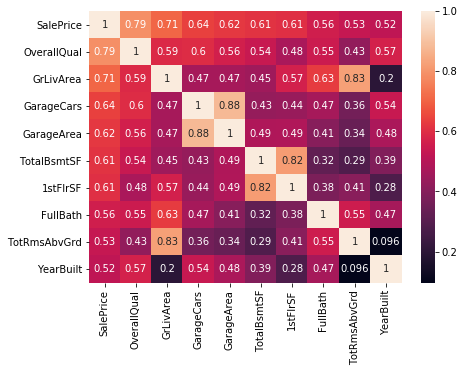

In [8]:
corrdata = train_numerics.corr()
cols = corrdata.nlargest(10,'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
plt.pyplot.subplots(figsize=(7, 5))
sbn.heatmap(cm, annot = True, yticklabels = cols.values, xticklabels = cols.values);

The creator of the dataset suggests removing all GrLivArea rows with a value above 4000, so we will look into that first.

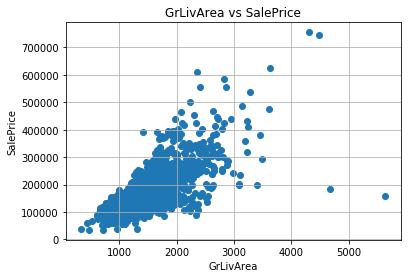

In [9]:
plt.pyplot.scatter(train_numerics.GrLivArea, train_numerics.SalePrice)
plt.pyplot.title("GrLivArea vs SalePrice")
plt.pyplot.xlabel("GrLivArea")
plt.pyplot.ylabel("SalePrice")
plt.pyplot.grid(True)
plt.pyplot.show()

In [10]:
train_numerics = train_numerics[train_numerics.GrLivArea < 4000]

Next up is TotalBsmtSF.

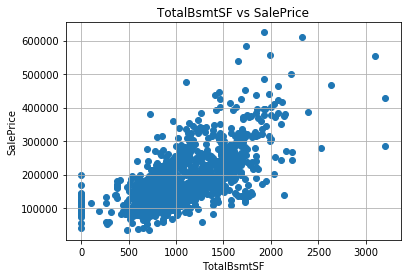

In [11]:
plt.pyplot.scatter(train_numerics.TotalBsmtSF, train_numerics.SalePrice)
plt.pyplot.title("TotalBsmtSF vs SalePrice")
plt.pyplot.xlabel("TotalBsmtSF")
plt.pyplot.ylabel("SalePrice")
plt.pyplot.grid(True)
plt.pyplot.show()

We seem to have 3 houses that have significantly larger basement surfaces than normal so we will remove them aswell.

In [12]:
#train_numerics = train_numerics[train_numerics.TotalBsmtSF < 3000]

Finally, we have 1stFlrSF.

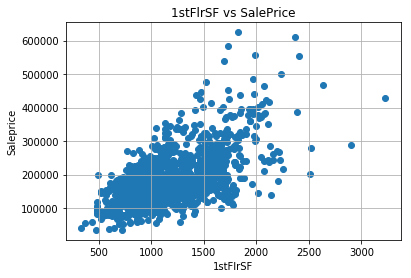

In [13]:
plt.pyplot.scatter(train_numerics['1stFlrSF'], train_numerics.SalePrice)
plt.pyplot.title("1stFlrSF vs SalePrice")
plt.pyplot.xlabel("1stFlrSF")
plt.pyplot.ylabel("Saleprice")
plt.pyplot.grid(True)
plt.pyplot.show()

In this case the outliers are't really big, but we'll remove the rows with values above 2500.

In [14]:
#train_numerics = train_numerics[train_numerics['1stFlrSF'] < 2500]

## Transforming skewed training data

For this dataset we will be using the log(x+1) transform function because of 0 values as seen in previous plots. We transform the data so as to reduce the impact of outliers on our model.

In [15]:
"""skew = train_numerics.skew()
skew = skew[abs(skew) > 0.5]
print(skew.shape[0], "skewed training features")
train_numerics[skew.index] = np.log1p(train_numerics[skew.index])"""
train_numerics = np.log1p(train_numerics)

## Transforming skewed test data

In [16]:
#don't forget to do the same thing on the data set too
"""skew_test = test_numerics.skew()
skew_test = skew_test[abs(skew_test) > 0.5]
print(skew_test.shape[0], "skewed test features")
test_numerics[skew_test.index] = np.log1p(test_numerics[skew_test.index])"""
test_numerics = np.log1p(test_numerics)

## Handling dummy variables

Our models require numeric values, so we will be turning all categorical variables into dummy variables.

In [17]:
#papa bless stackoverflow https://datascience.stackexchange.com/questions/18956/different-number-of-features-in-train-vs-test
num = len(train_categorics)
dataset = pd.concat(objs = [train_categorics, test_categorics], axis = 0) 
dataset = pd.get_dummies(dataset)
train_categorics = dataset[:num]
test_categorics = dataset[num:]

## Joining the features

In [18]:
train_numerics = train_numerics.drop('SalePrice', axis = 1)
df_train = pd.concat([train_numerics, train_categorics], axis = 1)
df_test = pd.concat([test_numerics, test_categorics], axis = 1)

print("New number of training features ", df_train.shape[1])
print("New number of test features ", df_test.shape[1])

New number of training features  288
New number of test features  288


## Imputing numerical features

In [19]:
imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean') #replace null rows with the mean of its column
df_train[df_train.columns] = imputer.fit_transform(df_train)
df_train.isna().sum().max() #check if there is any missing data left in the train dataset

0

## Splitting data

In [77]:
y = np.log1p(train.SalePrice) #target
X = df_train
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state = 420, test_size = 0.33) # split training data into training and validation data

In [78]:
df_test = df_test.fillna(0) # fill null values with 0

## Standardising data

In [79]:
scl = StandardScaler()

X_train[train_numerics.columns] = scl.fit_transform(X_train[train_numerics.columns])
X_test[test_numerics.columns] = scl.transform(X_test[test_numerics.columns])

scl_test = StandardScaler()

df_test[test_numerics.columns] = scl_test.fit_transform(df_test[test_numerics.columns]);

'scl = StandardScaler()\n\nX_train[features] = scl.fit_transform(X_train[features])\nX_test[features] = scl.transform(X_test[features])\n\nscl_test = StandardScaler()\ndf_test = df_test.fillna(0)\ntest_predict = df_test[features]\n\ntest_predict = scl_test.fit_transform(test_predict)'

## Creating the model

In [80]:
scorer = make_scorer(mean_squared_error, greater_is_better  = False)
#function to calculate RMSE score on training data
def rmse_cv_train(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 5))
    return rmse

#function to calculate RMSE score on training data
def rmse_cv_test(model):
    rmse = np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 5))
    return rmse

First we will try RandomForestRegressor as it's fast and accurate.

In [24]:
forest_model = RandomForestRegressor(n_estimators = 150)
forest_model.fit(X_train,y_train)


forest_pred = forest_model.predict(X_test)

print("RMSE with CV on training data is :", rmse_cv_train(forest_model).mean())

print("RMSE with CV on test data is :", rmse_cv_test(forest_model).mean())

0.8744351922157216
RMSE with CV on training data is : 0.14688313158049754
RMSE with CV on test data is : 0.16673875226556706


0.12470210478323758

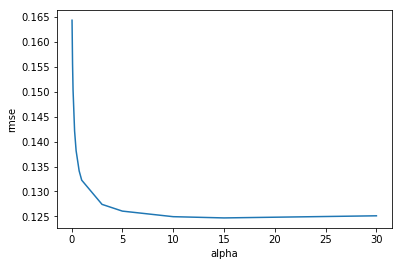

In [25]:
alphas = [0.05, 0.10, 0.15, 0.3, 0.45, 0.75, 1, 3, 5, 10, 15, 30]
#alphas = np.logspace(-3, -1, 30)
ridge = []
for alpha in alphas:
    ridge.append(rmse_cv_train(Ridge(alpha = alpha)).mean())
    
ridge = pd.Series(ridge, index = alphas)
ridge.plot()
plt.pyplot.xlabel("alpha")
plt.pyplot.ylabel("rmse")
ridge.min()

In [26]:
alphas = np.logspace(-3, -1, 30)
lasso = LassoCV(alphas = alphas, cv = 5).fit(X_train, y_train)

print("RMSE on training data",rmse_cv_train(lasso).mean())
print("RMSE on test data",rmse_cv_test(lasso).mean())

RMSE on training data 0.12362707055030069
RMSE on test data 0.13604838582910173


In [46]:
param_test1 ={ 'max_depth' : range(3,10,2), 'min_child_weight' : range(1,6,2) }

search1 = GridSearchCV(estimator = xgb.XGBRegressor ( learning_rate = 0.1, n_estimators = 140, max_depth =5, min_child_weight = 1, gamma = 0, subsample = 0.8, colsample_bytree = 0.8,n_thread = 4,
                                                 objective = 'reg:linear', scale_pos_weight = 1), param_grid = param_test1, scoring = 'r2', iid = False, cv = 5, n_jobs = 4)

search1.fit(X_train, y_train)
search1.cv_results_, search1.best_params_, search1.best_score_

({'mean_fit_time': array([2.31292377, 2.29612136, 2.2845098 , 2.6474966 , 2.55682168,
         2.5698216 , 3.30557909, 3.33647146, 3.234867  , 4.06871171,
         4.15651731, 3.3268003 ]),
  'std_fit_time': array([0.0109679 , 0.045442  , 0.01839755, 0.01841973, 0.02698447,
         0.03339832, 0.02315376, 0.04200554, 0.0142361 , 0.06537994,
         0.12793129, 0.22977842]),
  'mean_score_time': array([0.00760121, 0.00860257, 0.0090024 , 0.01040235, 0.01120205,
         0.01000314, 0.00980182, 0.0096025 , 0.01020241, 0.01290035,
         0.01020207, 0.00820551]),
  'std_score_time': array([0.00120042, 0.00149719, 0.00089484, 0.00215464, 0.00147017,
         0.00228108, 0.00147032, 0.00135657, 0.00343002, 0.00224744,
         0.00248243, 0.00255888]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
         

In [51]:
param_test2 = {
 'min_child_weight':[3,4,5,6,7]
}

search2 = GridSearchCV(estimator = xgb.XGBRegressor ( learning_rate = 0.1, n_estimators = 140, max_depth =5, min_child_weight = 1, gamma = 0, subsample = 0.8, colsample_bytree = 0.8,
                                                 objective = 'reg:linear', scale_pos_weight = 1, nthread = 4), param_grid = param_test2, scoring = 'r2', iid = False, cv = 5, n_jobs = 4)

search2.fit(X_train, y_train)
search2.best_params_, search2.best_score_

({'min_child_weight': 3}, 0.8965935575734042)

In [53]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

search3 = GridSearchCV(estimator = xgb.XGBRegressor ( learning_rate = 0.1, n_estimators = 140, max_depth =5, min_child_weight = 3, gamma = 0, subsample = 0.8, colsample_bytree = 0.8,
                                                 objective = 'reg:linear', scale_pos_weight = 1, nthread = 4), param_grid = param_test3, scoring = 'r2', iid = False, cv = 5, n_jobs = 4)

search3.fit(X_train, y_train)
search3.best_params_, search3.best_score_

({'gamma': 0.0}, 0.8965935575734042)

In [57]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

search3 = GridSearchCV(estimator = xgb.XGBRegressor ( learning_rate = 0.1, n_estimators = 140, max_depth =5, min_child_weight = 3, gamma = 0, subsample = 0.8, colsample_bytree = 0.8,
                                                 objective = 'reg:linear', scale_pos_weight = 1, nthread = 4), param_grid = param_test4, scoring = 'r2', iid = False, cv = 5, n_jobs = 4)

search3.fit(X_train, y_train)
search3.best_params_, search3.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.9}, 0.9015238521618356)

In [60]:
param_test5 ={'reg_alpha' : np.logspace(-3, -1, 50)}

search3 = GridSearchCV(estimator = xgb.XGBRegressor ( learning_rate = 0.1, n_estimators = 140, max_depth =5, min_child_weight = 3, gamma = 0, subsample = 0.9, colsample_bytree = 0.8,
                                                 objective = 'reg:linear', scale_pos_weight = 1, nthread = 4), param_grid = param_test5, scoring = 'r2', iid = False, cv = 5, n_jobs = 4)

search3.fit(X_train, y_train)
search3.best_params_, search3.best_score_

({'reg_alpha': 0.002559547922699536}, 0.9057255857402818)

In [74]:
alpha = search3.best_params_['reg_alpha']
print(alpha)

0.002559547922699536


In [ ]:
param_test5 ={'n_estimators' : [1000, 2000, 3000, 4000, 5000],
              'learning_rate' : [0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.01]}

search3 = GridSearchCV(estimator = xgb.XGBRegressor ( learning_rate = 0.1, n_estimators = 140, max_depth =5, min_child_weight = 3, gamma = 0, subsample = 0.9, colsample_bytree = 0.8,
                                                 objective = 'reg:linear', scale_pos_weight = 1, nthread = 4), param_grid = param_test5, scoring = 'r2', iid = False, cv = 5, n_jobs = 4)

search3.fit(X_train, y_train)
search3.best_params_, search3.best_score_

In [91]:
xgb_model = xgb.XGBRegressor(n_estimators= 3000, max_depth=5, learning_rate = 0.01, objective ='reg:linear', min_child_weight = 3, n_thread = 4,
                             reg_alpha = alpha, subsample = 0.9, colsample_bytree = 0.8, scale_pos_weight = 1, gamma = 0)
xgb_model.fit(X_train, y_train)

print("RMSE on training data",rmse_cv_train(xgb_model).mean())
print("RMSE on test data",rmse_cv_test(xgb_model).mean())

RMSE on training data 0.12801145882590398
RMSE on test data 0.16353817798503084


## Making the prediction

In [93]:
prediction_xgb = xgb_model.predict(df_test)
prediction_lasso = lasso.predict(df_test)
prediction_final = np.expm1(prediction_lasso* 0.7 + prediction_xgb * 0.3)

print("Initial prediction:", prediction[:10], "\n")
print("Final prediction :", prediction_final[:10])


Initial prediction: [11.735351 11.977366 12.150361 12.151275 12.142844 12.040285 12.059849
 12.024786 12.117457 11.761835] 

Final prediction : [121726.25791647 163151.33504856 188379.82897507 199571.7084806
 193463.81766261 174032.85712252 176416.83168164 165517.3923404
 198111.20168705 121292.06055367]


In [94]:
submission = pd.DataFrame()
submission['Id'] = test.Id

submission['SalePrice'] = prediction_final

submission.to_csv('submission.csv', index = False)

In [95]:
submission.describe()

,Id,SalePrice
count,1459.000000,1459.000000
mean,2190.000000,180899.223796
std,421.321334,76368.940909
min,1461.000000,49115.925701
25%,1825.500000,130111.871609
50%,2190.000000,160843.879909
75%,2554.500000,211768.347267
max,2919.000000,634425.902364
